# Preparación

## Instalación e importación de librerías

In [ ]:
!pip3 install fastai
!pip3 install pydicom

In [ ]:
import cv2

from fastai.basics import *
from fastai.callback import *
from fastai.vision import *
from fastai import *

import glob

from google.colab import output

import numpy as np
import pandas as pd

import pydicom

import os
import random

In [6]:
# Función que carga y procesa las imágenes dcm
def load_image(sample_path):
    ds = pydicom.dcmread(sample_path)
    img = ds.pixel_array
    p01 = np.percentile(img.ravel(), 1)
    p99 = np.percentile(img.ravel(), 99)
    img[img > p99] = p99
    img[img < p01] = p01
    if ds.data_element('PhotometricInterpretation').value == 'MONOCHROME1':
        img = np.invert(img)
    img = (img - img.min()) / (img.max() - img.min())
    return img

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Descarga y conversión de imágenes

In [ ]:
if not (os.path.isdir('train') and os.path.isdir('test') and os.path.exists('sample_submission.csv') and os.path.exists('train.csv')):
  with zipfile.ZipFile("edemdataproject4.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

if os.path.exists('edemdataproject4.zip'):
  !rm edemdataproject4.zip

In [ ]:
# Creación de los directorios
os.mkdir('./drive/MyDrive/dp4')
inputdir = './drive/MyDrive/train/'
outdir = './drive/MyDrive/dp4/train/'

if not os.path.exists(outdir):
  os.mkdir(outdir)
if not os.path.exists(outdir_np):
  os.mkdir(outdir_np)

test_list = [ f for f in  os.listdir(inputdir)]

k = 1
for f in test_list:
    img = load_image(inputdir + f)
    np.save(outdir_np + f.replace('.dcm','.npy'),img)
    img = img*255
    cv2.imwrite(outdir + f.replace('.dcm', '.jpeg'), img)
    print(f"{k} of {len(os.listdir(inputdir))}")
    k += 1


inputdir = './drive/MyDrive/test/'
outdir = './drive/MyDrive/dp4/test/'
outdir = './drive/MyDrive/dp4np/test/'
if not os.path.exists(outdir):
  os.mkdir(outdir)
if not os.path.exists(outdir_np):
  os.mkdir(outdir_np)

test_list = [ f for f in  os.listdir(inputdir)]

k = 1
for f in test_list:   # remove "[:10]" to convert all images
    img = load_image(inputdir + f)
    np.save(outdir_np + f.replace('.dcm','.npy'),img) # write numpy array
    img = img*255
    cv2.imwrite(outdir + f.replace('.dcm', '.jpeg'), img)
    print(f"{k} of {len(os.listdir(inputdir))}")
    k += 1


In [ ]:
import shutil

zip_name = 'dp4.zip'
directory_name = './drive/MyDrive/dp4/'

# Create 'path\to\zip_file.zip'
shutil.make_archive(zip_name, 'zip', directory_name)

'/content/dp4.zip.zip'

In [ ]:
# Create folders inside train
for folder in list(train_csv.Target.unique()):
  os.mkdir(f'./drive/MyDrive/dp4/train/{folder}')

# Move files from train folder
for file in glob.glob("./drive/MyDrive/dp4/train/*.jpeg"):
  folder = train_csv.loc[train_csv.SOPInstanceUID == file[26:-5]].Target.values[0]
  path_dest = f"./drive/MyDrive/dp4/train/{folder}/" + file[26:]
  os.system(f"mv {file} {path_dest}")

In [ ]:
train_csv = pd.read_csv('./drive/MyDrive/train.csv')

## Creación de nuevas imágenes

### Definición de funciones

In [8]:
# Rotación de imágenes con un grado determinado de grados

def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

In [9]:
# Aplicación de distintos tipos de ruido en las imágenes

def noisy(noise_typ,image):
  if noise_typ == "gauss":
    row,col,ch= image.shape
    mean = 0
    var = 0.1
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss
    return noisy
  elif noise_typ == "s&p":
      row,col,ch = image.shape
      s_vs_p = 0.5
      amount = 0.004
      out = np.copy(image)
      # Salt mode
      num_salt = np.ceil(amount * image.size * s_vs_p)
      coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
      out[coords] = 1

      # Pepper mode
      num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
      coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
      out[coords] = 0
      return out
  elif noise_typ == "poisson":
      vals = len(np.unique(image))
      vals = 2 ** np.ceil(np.log2(vals))
      noisy = np.random.poisson(image * vals) / float(vals)
      return noisy
  elif noise_typ =="speckle":
      row,col,ch = image.shape
      gauss = np.random.randn(row,col,ch)
      gauss = gauss.reshape(row,col,ch)        
      noisy = image + image * gauss
      return noisy

In [10]:
 def cont_bright(image, alpha = 1.0, beta = 0):
  new_image = np.zeros(image.shape, image.dtype)
  # Alpha value [1.0-3.0]
  # Beta value [0-100]
  
  for y in range(image.shape[0]):
      for x in range(image.shape[1]):
          for c in range(image.shape[2]):
              new_image[y,x,c] = np.clip(alpha*image[y,x,c] + beta, 0, 255)
  return(new_image)

In [11]:
# Zoom en las imágenes en tanto por 1

def paddedzoom2(img, zoomfactor=0.8):
    h = img.shape[0]
    w = img.shape[1]
    M = cv2.getRotationMatrix2D( (w/2,h/2), 0, zoomfactor) 
    
    return cv2.warpAffine(img, M, img.shape[:-1])


In [12]:
# Aumento/disminución de brillo

def change_brightness(img, value=30, increase = True):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    if increase:
      sat = 255
      lim = sat - value
      v[v > lim] = sat
      v[v <= lim] += value
    else:
      sat = 0
      lim = sat + value
      v[v < lim] = sat
      v[v >= lim] -= value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [14]:
# Movimiento y recorte de la imagen según el movimiento realizado

def move_img(img, per):
  per = per/100
  w = img.shape[1]
  h = img.shape[0]

  dx = random.randint(-int(w*per), int(w*per))
  dy = random.randint(-int(h*per), int(h*per))

  M = np.float32([
    [1, 0, dx],
    [0, 1, dy]
  ])

  img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))

  if dx >= 0:
    x_inf = dx
    x_sup = img.shape[1]
  else:
    x_inf = 0
    x_sup = img.shape[1]+dx
  
  if dy >= 0:
    y_inf = dy
    y_sup = img.shape[0]
  else:
    y_inf = 0
    y_sup = img.shape[0]+dy

  return(img[y_inf:y_sup, x_inf:x_sup, :])
  # return(img)

In [ ]:
for i in glob.glob("./drive/MyDrive/dp4/train/*"):
  os.mkdir(i)

In [74]:
# Borrar imágenes creadas previamente si es necesario

created_imgs = glob.glob('./drive/MyDrive/dp4_copy/train/*/crea*')
for i in created_imgs:
  os.system(f'rm {i}')

### Primera iteración

#### Aumento de las categorias pequeñas

In [91]:
# Lista de categorías con 20 imágenes o menos
cat = list([4, 8, 18, 19])

In [92]:
# Primer aumento
for k in cat:
  rot_deg = 180
  if k == 4:
    rot_deg = 3
  if k == 18:
    rot_deg == 45
  if k == 19:
    rot_deg == 30

  for i in glob.glob(f'./drive/MyDrive/dp4/train/{k}/*'):
    img = cv2.imread(i)
    
    img = np.fliplr(img)
    img = paddedzoom2(img, random.uniform(0.85, 1.15))
    img = move_img(img, 5)
    img = rotate_image(img, random.randint(-rot_deg, rot_deg))
    
    cv2.imwrite(f'./drive/MyDrive/dp4/train/{k}/created_0_{i[-43:]}', img)

In [93]:
# Segundo aumento
for k in cat:
  rot_deg = 180
  if k == 4:
    rot_deg = 3
  if k == 18:
    rot_deg == 45
  if k == 19:
    rot_deg == 30

  for i in glob.glob(f'./drive/MyDrive/dp4/train/{k}/crea*'):
    img = cv2.imread(i)
    
    img = np.fliplr(img)
    img = change_brightness(img, 25, rand_bool(0.5))
    img = cv2.GaussianBlur(img, (9,9), 0)
    img = noisy("s&p", img)
    img = paddedzoom2(img, random.uniform(0.85, 1.15))
    img = move_img(img, 5)
    img = rotate_image(img, random.randint(-rot_deg, rot_deg))
    
    cv2.imwrite(f'./drive/MyDrive/dp4/train/{k}/created_1_{i[-43:]}', img)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


#### Aumento de categorías pequeñas y medianas

In [94]:
cat = [5, 7, 10, 12, 17, 20]

In [95]:
for k in cat:
  rot_deg = 180
  if k == 5 or k == 17:
    rot_deg = 3
  if k == 20:
    rot_deg = 10
  if k == 7 or k == 10:
    rot_deg == 20
  if k == 12:
    rot_deg == 45

  for i in glob.glob(f'./drive/MyDrive/dp4/train/{k}/*'):
    img = cv2.imread(i)
    
    img = np.fliplr(img)
    img = change_brightness(img, 25, rand_bool(0.5))
    img = cv2.GaussianBlur(img, (9,9), 0)
    img = noisy("s&p", img)
    img = paddedzoom2(img, random.uniform(0.85, 1.15))
    img = move_img(img, 5)
    img = rotate_image(img, random.randint(-rot_deg, rot_deg))
    
    cv2.imwrite(f'./drive/MyDrive/dp4/train/{k}/created_0_{i[-43:]}', img)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


#### Comprobación de la distribución de las imágenes por categorías

In [96]:
list_train_folders = os.listdir('./drive/MyDrive/dp4/train')
images_train = list()

for i in list_train_folders:
  n_items = len(glob.glob(f'./drive/MyDrive/dp4/train/{i}/*'))
  images_train.append(n_items)
  print(f"{i}: {n_items} images")


14: 96 images
3: 579 images
9: 46 images
0: 64 images
2: 60 images
13: 62 images
6: 55 images
15: 52 images
11: 81 images
21: 50 images
16: 64 images
12: 60 images
1: 64 images
5: 72 images
7: 48 images
8: 54 images
10: 60 images
19: 30 images
18: 48 images
17: 72 images
20: 48 images
4: 42 images


### Segunda iteración

In [97]:
# Categorías con 40 imágenes o menos
cat = [1, 4, 5, 7, 8, 9, 10, 12, 13, 16, 17, 18, 19, 20]

In [98]:
for k in cat:
  rot_deg = 180
  if k == 4:
    rot_deg = 3
  if k == 18:
    rot_deg == 45
  if k == 19:
    rot_deg == 30

  for i in glob.glob(f'./drive/MyDrive/dp4/train/{k}/*'):
    img = cv2.imread(i)
    
    img = np.fliplr(img)
    img = change_brightness(img, 25, rand_bool(0.5))
    img = cv2.GaussianBlur(img, (9,9), 0)
    img = noisy("s&p", img)
    img = paddedzoom2(img, random.uniform(0.85, 1.15))
    img = move_img(img, 5)
    img = rotate_image(img, random.randint(-rot_deg, rot_deg))
    
    cv2.imwrite(f'./drive/MyDrive/dp4/train/{k}/created_2_{i[-45:]}', img)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


#### Comprobación de la distribución de imágenes por categoría

In [99]:
list_train_folders = os.listdir('./drive/MyDrive/dp4/train')
images_train = list()

for i in list_train_folders:
  n_items = len(glob.glob(f'./drive/MyDrive/dp4/train/{i}/*'))
  images_train.append(n_items)
  print(f"{i}: {n_items} images")


14: 96 images
3: 579 images
9: 46 images
0: 64 images
2: 60 images
13: 62 images
6: 55 images
15: 52 images
11: 81 images
21: 50 images
16: 64 images
12: 60 images
1: 64 images
5: 72 images
7: 48 images
8: 54 images
10: 60 images
19: 30 images
18: 48 images
17: 72 images
20: 48 images
4: 42 images


# Carga, entrenamiento y predicción

## Carga del modelo Densenet201

### Definición de los datos de entrenamiento y test

In [19]:
ratio = 10
pct_val = ratio/100

In [20]:
# Load data
batch_size = 8
size = 256
data = ImageDataBunch.from_folder(path="drive/MyDrive/dp4_copy", train="train", test="test", 
                                  valid_pct=pct_val, 
                                  ds_tfms=get_transforms(), size=size, 
                                  bs=batch_size
                                  ).normalize(imagenet_stats)

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:859.)
  return _solve_func(B,A)[0][:,0]


### Definición del modelo

In [21]:
learn = cnn_learner(
    data, 
    models.densenet201, 
    metrics = [accuracy, FBeta(average='macro')]
    )

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

In [22]:
learn.model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine

## Entrenamiento

### Búsqueda del ratio de aprendizaje

epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.45E-07
Min loss divided by 10: 2.69E-03


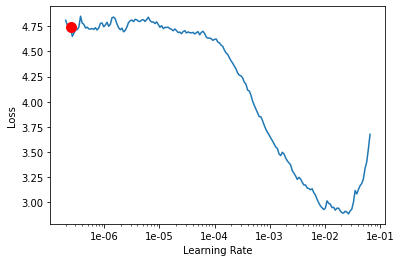

In [23]:
# Búsqueda automática del ratio de aprendizaje óptimo
learn.lr_find(stop_div=False, num_it=200, end_lr = 1e-01)
learn.recorder.plot(suggestion=True)

In [53]:
# Se escoge el segundo por no ser excesivamente pequeño y tardar menos en converger
lr = 2.69e-03

In [35]:
# Guardar el modelo en el epoch que obtenga el máximo accuracy
learn.callback_fns.append(partial(callbacks.SaveModelCallback, 
                              monitor='accuracy',
                              mode='max',
                              name=f'checkpoint_d201_acc_{ratio}'))

# Guardar el modelo en el epoch que obtenga el máximo FBeta
learn.callback_fns.append(partial(callbacks.SaveModelCallback, 
                              monitor='f_beta',
                              mode='max',
                              name=f'checkpoint_d201_f_{ratio}'))

# Guardar el modelo en el epoch que obtenga el mínimo valid_loss
learn.callback_fns.append(partial(callbacks.SaveModelCallback, 
                              monitor='valid_loss',
                              mode='min',
                              name=f'checkpoint_d201_vl_{ratio}'))

In [36]:
# Entrenamiento en 85 epochs
learn.fit_one_cycle(85, max_lr=slice(lr))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,2.128668,0.920783,0.745856,0.578482,01:50
1,1.339384,0.560643,0.834254,0.734047,01:45
2,1.022301,0.396963,0.872928,0.785861,01:43
3,0.752410,0.335116,0.895028,0.837476,01:43
4,0.719898,0.350692,0.895028,0.823247,01:43
5,0.670970,0.304057,0.906077,0.848804,01:43
6,0.576625,0.255322,0.917127,0.876865,01:43
7,0.612872,0.225761,0.944751,0.908494,01:44
8,0.513896,0.300837,0.917127,0.871391,01:44
9,0.493155,0.313149,0.906077,0.834122,01:45


Better model found at epoch 0 with accuracy value: 0.7458563446998596.
Better model found at epoch 0 with f_beta value: 0.5784815549850464.
Better model found at epoch 1 with accuracy value: 0.8342541456222534.
Better model found at epoch 1 with f_beta value: 0.7340465188026428.
Better model found at epoch 2 with accuracy value: 0.8729282021522522.
Better model found at epoch 2 with f_beta value: 0.7858605980873108.
Better model found at epoch 3 with accuracy value: 0.8950276374816895.
Better model found at epoch 3 with f_beta value: 0.8374757766723633.
Better model found at epoch 5 with accuracy value: 0.9060773253440857.
Better model found at epoch 5 with f_beta value: 0.8488037586212158.
Better model found at epoch 6 with accuracy value: 0.9171270728111267.
Better model found at epoch 6 with f_beta value: 0.8768650889396667.
Better model found at epoch 7 with accuracy value: 0.9447513818740845.
Better model found at epoch 7 with f_beta value: 0.9084939956665039.
Better model found a

In [84]:
# Guardar el modelo obtenido en el último epoch
learn.save(f"checkpoint_d201_all_{ratio}")

**Nota**: en este caso concreto no se ha decantado por el entrenamiento con las capas descongeladas puesto que no ha aportado algún tipo de mejora al respecto.

## Predicción

In [37]:
# Carga de sample_submission
sample_sub = pd.read_csv("./drive/MyDrive/sample_submission.csv")

### Modelo con todos los epochs

In [72]:
test_files_path = glob.glob('./drive/MyDrive/dp4/test/*.jpeg')
test_files = list(map(lambda x: x[25:-5], test_files_path))

for i in range(len(test_files_path)):
  img = data.test_ds[i][0]
  predicted = learn_0.predict(img)
  predicted = int(predicted[0])
  sample_sub.loc[sample_sub.SOPInstanceUID == test_files[i], "Target"] = predicted

sample_sub.Target.replace({
    2: 10, 
    3: 11, 
    4: 12, 
    5: 13,
    6: 14, 
    7: 15, 
    8: 16, 
    9: 17, 
    10: 18, 
    11: 19, 
    12: 2, 
    13: 20, 
    14: 21, 
    15: 3, 
    16: 4, 
    17: 5, 
    18: 6, 
    19: 7, 
    20: 8, 
    21: 9
}, inplace=True)

# Guardar sample submission
sample_sub.to_csv('sample_submission.csv', index=False)

# Notificación sonora
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

In [73]:
os.system(f"cp sample_submission.csv drive/MyDrive/sample_submission_201_all_{ratio}_freeze.csv")

0

### Modelo con el mejor accuracy

In [74]:
learn_0.load(f'/content/drive/MyDrive/dp4_copy/models/checkpoint_d201_acc_{ratio}')


Learner(data=ImageDataBunch;

Train: LabelList (1630 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
4,2,6,15,14
Path: drive/MyDrive/dp4_copy;

Valid: LabelList (181 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
11,13,6,19,3
Path: drive/MyDrive/dp4_copy;

Test: LabelList (328 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: drive/MyDrive/dp4_copy, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   

In [75]:
test_files_path = glob.glob('./drive/MyDrive/dp4/test/*.jpeg')
test_files = list(map(lambda x: x[25:-5], test_files_path))

for i in range(len(test_files_path)):
  img = data.test_ds[i][0]
  predicted = learn_0.predict(img)
  predicted = int(predicted[0])
  sample_sub.loc[sample_sub.SOPInstanceUID == test_files[i], "Target"] = predicted

# for i in test_files_path:
#   img = PIL.Image.open(i)
#   img = img.resize((256, 256))
#   img = vision.Image(pil2tensor(img, np.float32).div(255))
#   predicted = learn_2.predict(img)
#   predicted = int(predicted[0])
#   sample_sub.loc[sample_sub.SOPInstanceUID == i[25:-5], "Target"] = predicted

sample_sub.Target.replace({
    2: 10, 
    3: 11, 
    4: 12, 
    5: 13,
    6: 14, 
    7: 15, 
    8: 16, 
    9: 17, 
    10: 18, 
    11: 19, 
    12: 2, 
    13: 20, 
    14: 21, 
    15: 3, 
    16: 4, 
    17: 5, 
    18: 6, 
    19: 7, 
    20: 8, 
    21: 9
}, inplace=True)

# Guardar sample submission
sample_sub.to_csv('sample_submission.csv', index=False)

# Notificación sonora
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

In [76]:
os.system(f"cp sample_submission.csv drive/MyDrive/sample_submission_201_acc_{ratio}_freeze.csv")

0

#### Predict test with the best model by FBeta

In [43]:
learn_0.load(f'/content/drive/MyDrive/dp4/models/checkpoint_d201_f_{ratio}')

Learner(data=ImageDataBunch;

Train: LabelList (1630 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
4,2,6,15,14
Path: drive/MyDrive/dp4_copy;

Valid: LabelList (181 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
11,13,6,19,3
Path: drive/MyDrive/dp4_copy;

Test: LabelList (328 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: drive/MyDrive/dp4_copy, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   

In [44]:
test_files_path = glob.glob('./drive/MyDrive/dp4/test/*.jpeg')
test_files = list(map(lambda x: x[25:-5], test_files_path))

for i in range(len(test_files_path)):
  img = data.test_ds[i][0]
  predicted = learn_0.predict(img)
  predicted = int(predicted[0])
  sample_sub.loc[sample_sub.SOPInstanceUID == test_files[i], "Target"] = predicted

# for i in test_files_path:
#   img = PIL.Image.open(i)
#   img = img.resize((256, 256))
#   img = vision.Image(pil2tensor(img, np.float32).div(255))
#   predicted = learn_2.predict(img)
#   predicted = int(predicted[0])
#   sample_sub.loc[sample_sub.SOPInstanceUID == i[25:-5], "Target"] = predicted

sample_sub.Target.replace({
    2: 10, 
    3: 11, 
    4: 12, 
    5: 13,
    6: 14, 
    7: 15, 
    8: 16, 
    9: 17, 
    10: 18, 
    11: 19, 
    12: 2, 
    13: 20, 
    14: 21, 
    15: 3, 
    16: 4, 
    17: 5, 
    18: 6, 
    19: 7, 
    20: 8, 
    21: 9
}, inplace=True)

# Guardar sample submission
sample_sub.to_csv('sample_submission.csv', index=False)

output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

In [45]:
os.system(f"cp sample_submission.csv drive/MyDrive/sample_submission_201_f_{ratio}_freeze.csv")

0